<a href="https://colab.research.google.com/github/kdambrowski/midi-internship/blob/master/Piano_For_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install miditoolkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00


In [3]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00


In [4]:
!pip install chorder -q

In [25]:
!pip install pre-commit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 29.2 MB/s eta 0:00:00


Library

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import math
from chorder import Chord
from miditoolkit.midi import parser as mid_parser
from miditoolkit.midi import containers
from chorder.dechorder import Dechorder

Classes and functions

In [6]:
record_long_limit = 120
thresholds = 2
pitch_threshold = [2, 3, 4, 5]
min_chord_size = 3
max_chord_size = 5

In [7]:
def get_sec_to_min(df):
  """Converts the duration of musical notes in seconds to minutes,
    considering the specified record long limit."""
  last_note_end = df.end.max()
  if last_note_end > record_long_limit:
    record_time_min = last_note_end/60
    return record_time_min
  return last_note_end


def calculate_octave(pitch):
  """Calculating octave for given pitch"""
  return (pitch // 12) - 1


def count_decimal_places(df, col):
  """
    Count the maximum number of decimal places
     in a specified column of a DataFrame."""
  max_precision = 0
  for val in df[col]:
    str_num = str(val)
    if '.' in str_num:
      num_precision = len(str_num) - str_num.index('.') - 1
      if num_precision > max_precision:
        max_precision = num_precision
  return max_precision


def find_chords(df, pitch_threshold, min_chord_size=3, max_chord_size=5):
  """
  Identify and label chords in a DataFrame containing musical pitch data.

  Args:
      * df (DataFrame): DF with musical pitch data.
      * pitch_threshold (list): A list of pitch differences
      that define the threshold for identifying chords.
      * min_chord_size (int, optional):
      The minimum size of a chord. Defaults to 3.
      * max_chord_size (int, optional):
      The maximum size of a chord. Defaults to 5.

  Returns:
      3 differece variables : A variables containing:
          - List of detected chords (each chord is a list of pitch values).
          - List of indices where chords were detected.
          - A modified copy of the input DataFrame with added
           'chord' column indicating the chord number."""
  chords = []
  chord_index = []
  chord_num = 1
  df_copy = df.copy()
  chord_sizes_5_4 = list(range(max_chord_size, min_chord_size - 1, -1))
  chord_sizes_3 = list(range(min_chord_size - 1, 2, -1))

  for i in range(len(df)):
    for chord_size in chord_sizes_5_4 + chord_sizes_3:
      index_list = df['pitch'][i:i + chord_size].index.to_list()

      if not any(idx in chord_index for idx in index_list):
        chord_frame = sorted(df['pitch'][i:i + chord_size].to_list())
        chord_set = set(chord_frame)

        if len(chord_set) == chord_size:
          results = [abs(chord_frame[j + 1] - chord_frame[j]) for j in range(len(chord_frame) - 1)]
          if max(results) <= max(pitch_threshold):
            chords.append(df['pitch'][i:i + chord_size].to_list())
            chord_index.extend(index_list)


            df_copy.loc[index_list, 'chord'] = chord_num
            chord_num += 1

  return chords, chord_index, df_copy


def get_speed_calculation(df):
  """
    Calculate the speed of musical notes in beats per second (bps)
     or beats per minute (bpm) based on the given DataFrame."""
  bps = df['start'].apply(lambda x: int(x))
  if df['end'].max() < record_long_limit:
    return bps
  else:
    return (bps// 60)


def draw_speed_plot(df,
                    bps,
                    record_name = 'default_record_name',
                    y_name = 'note'):
  """
    Draw a plot showing the quantities of notes or chords
     in relation to time or speed."""
  plt.title(f'Chart time/speed in record "{record_name}"')
  plt.ylabel(f'Quantities of {y_name} in tick')
  if y_name == 'note':
    plt.plot(bps.value_counts(sort = False))
  else:
    _, _, chord_df = find_chords(df,
                                pitch_threshold,
                                min_chord_size,
                                max_chord_size)
    chord_df['tick'] = bps
    chord_counts = chord_df.groupby('tick')['chord'].nunique()
    plt.plot(chord_counts.index, chord_counts.values)
  if df['end'].max() < record_long_limit:
    plt.xlabel('Time [s]')
  else:
    plt.xlabel('Time [min]')
  plt.show()


def draw_notes_at_same_time_plot(df,
                                 start_col,
                                 time_threshold=0.2,
                                 top_number=None):
  """
    Draw a bar plot showing the frequency of the number of simultaneous
    notes played at the same time.
  """
  df_sorted = df.sort_values(by=start_col)
  time_diffs = np.diff(df_sorted[start_col])
  chords_count = np.ones(len(time_diffs), dtype=int)
  for i, time_diff in enumerate(time_diffs):
    j = i + 1
    while j < len(time_diffs) and time_diffs[j] <= time_threshold:
      chords_count[i] += 1
      j += 1
  unique_counts, count_occurrences = np.unique(chords_count, return_counts=True)
  if top_number is not None:
    top_number = min(top_number, len(unique_counts))
    top_indices = np.argsort(count_occurrences)[-top_number:]
    unique_counts = unique_counts[top_indices]
    count_occurrences = count_occurrences[top_indices]
  plt.bar(unique_counts, count_occurrences)
  plt.xlabel('Number of simultaneous notes')
  plt.ylabel('Occurrences')
  plt.title('Frequency of Simultaneous Notes')
  plt.show()



def to_integer(x):
  return int(x)


def get_table_with_counts(df):
  """
    Generate a modified DataFrame with added columns
    representing the counts of start and end times.
  """
  modified_df = df.copy()
  modified_df['time_stamp'] = modified_df['start'].apply(to_integer)
  start_counts = modified_df['start'].value_counts()
  modified_df['start_counts'] = modified_df['start'].map(start_counts)
  end_counts = modified_df['end'].value_counts()
  modified_df['end_counts'] = modified_df['end'].map(end_counts)
  return modified_df


def get_table_with_chords(df,
                          min_threshold=1,
                           max_threshold=100,):
  """
    Generate a modified DataFrame with
    filtered rows based on start and end counts.
  """
  min_start_value = (df['start_counts'] > min_threshold)
  max_start_value = (df['start_counts'] < max_threshold)
  df_start_filter = df[ (min_start_value) & (max_start_value)]
  min_end_value = (df_start_filter['start_counts'] > min_threshold)
  max_end_value = (df_start_filter['start_counts'] < max_threshold)
  df_end_filter = df_start_filter[(min_end_value) & (max_end_value)]
  return df_end_filter


def get_dict_for_list_counter(list_to_counter)
  """
    Count the occurrences of lists in a list and create
    a dictionary of their counts.
  """
  dict_chord_counts = {}
  for chord in list_to_counter:
    chord_tuple = tuple(chord)
    if chord_tuple in dict_chord_counts:
      dict_chord_counts[chord_tuple] += 1
    else:
      dict_chord_counts[chord_tuple] = 1
  return dict_chord_counts

def draw_chords_counter_plot(list_to_counter, top=None):
  """
    Draw a bar plot showing
    the frequency of occurrences of different chord lists.
  """
  chord_dict_counter = get_dict_for_list_counter(list_to_counter)
  chord_items = list(chord_dict_counter.items())

  if top is not None:
    sorted_chords = sorted(chord_items,
                            key=lambda item: item[1],
                            reverse=True)
    sorted_chords = sorted_chords[:top]
    chords_list, counts = zip(*sorted_chords)
  else:
    chords_list, counts = zip(*chord_items)

  plt.figure(figsize=(12, 6))
  plt.bar([str(chord) for chord in chords_list], counts)
  plt.xlabel('Chords')
  plt.ylabel('Occurrences')
  plt.title('Frequency of Chords in Record')
  plt.xticks(rotation=90, ha='center', fontsize=7)
  plt.xlim(-0.4, len(chords_list) - 0.3)
  plt.tight_layout()
  plt.show()




# Data_load

In [8]:
dataset = load_dataset("roszcz/internship-midi-data-science", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

In [9]:
record = dataset[0]
df = pd.DataFrame(record["notes"])
print(df.head())

        end  pitch     start  velocity
0  2.058438     42  1.934219        74
1  2.990469     66  1.935573        84
2  2.044531     30  1.948229        76
3  2.613073     49  2.556146        77
4  2.618333     54  2.564844        59


# Data_exploration

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88887 entries, 0 to 88886
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   end       88887 non-null  float64
 1   pitch     88887 non-null  int64  
 2   start     88887 non-null  float64
 3   velocity  88887 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 2.7 MB


In [11]:
df.describe()

,end,pitch,start,velocity
count,88887.000000,88887.000000,88887.000000,88887.000000
mean,4957.979001,60.393961,4957.737860,75.824294
std,3137.172265,13.333204,3137.107324,17.375164
min,2.044531,22.000000,1.934219,1.000000
25%,2173.164062,52.000000,2173.096667,66.000000
50%,4964.847396,61.000000,4964.544792,78.000000
75%,7526.466641,69.000000,7526.213932,88.000000
max,10856.903594,98.000000,10856.752188,120.000000


#Speed

## Speed 1.1-2 time vs. speed

For a given record, create a chart of time vs. speed.
If the record is longer than 120 seconds, use minutes as the time unit.
Use "notes played per second" as the speed unit.

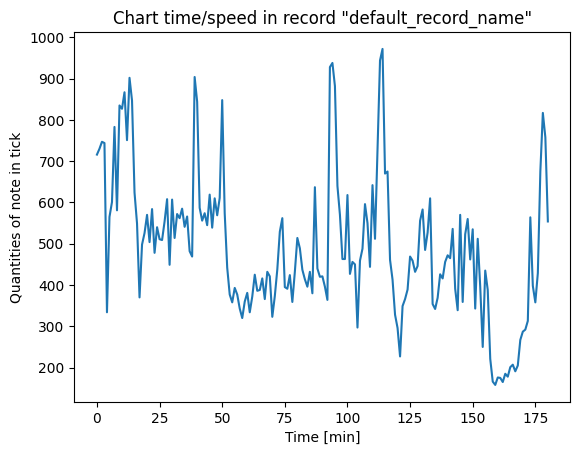

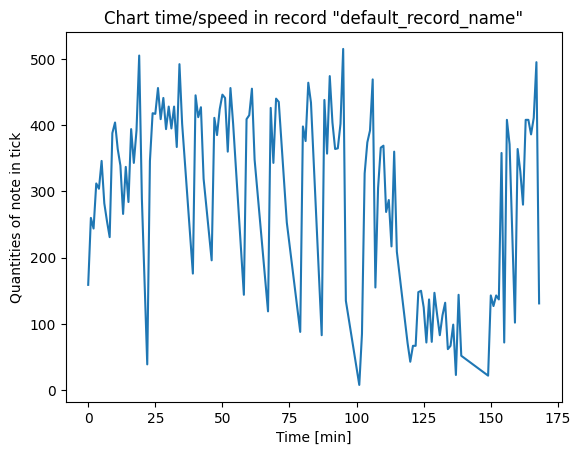

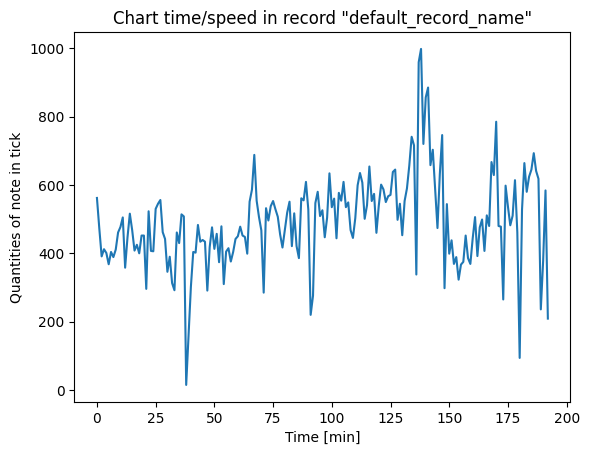

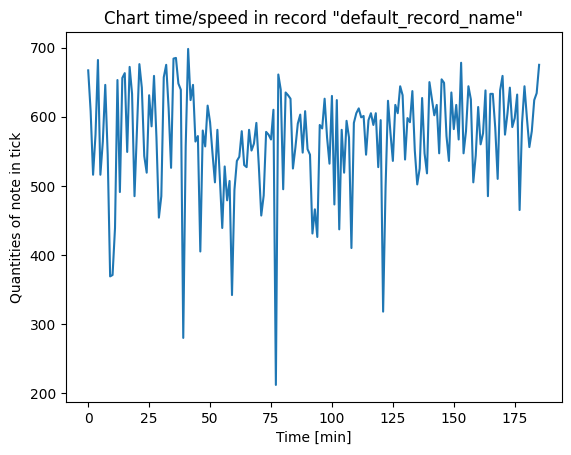

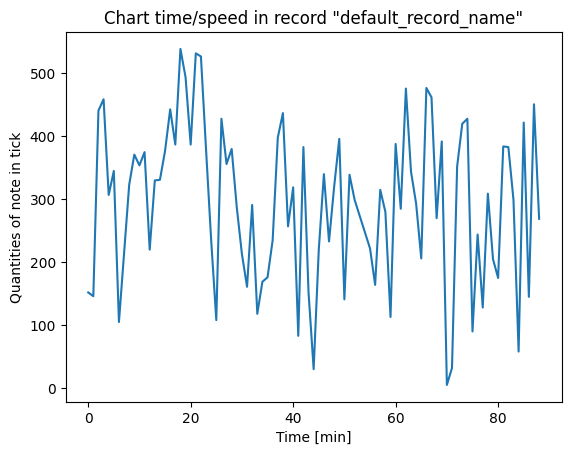

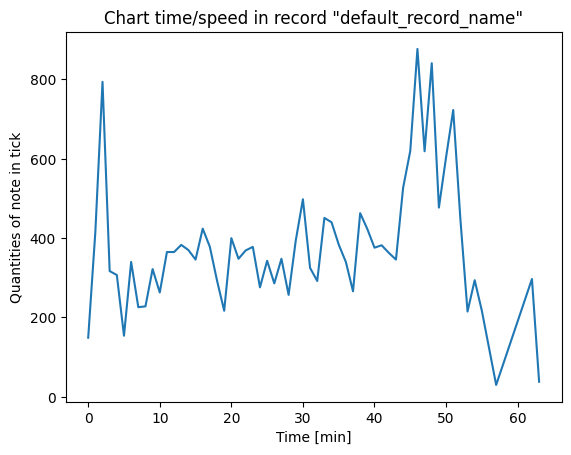

In [12]:
for record in dataset:
  df_speed = pd.DataFrame(record['notes'])
  bits_calculation = get_speed_calculation(df_speed)
  draw_speed_plot(df_speed, bits_calculation)


## Speed 2.1 Number of notes

Create a chart showing the number of notes pressed at the same time. Experiment with different thresholds.

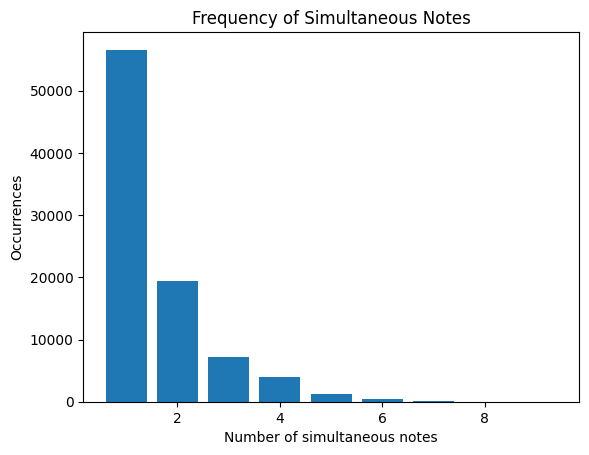

In [13]:
draw_notes_at_same_time_plot(df, 'start', 0.01, 10)

#Chords

##Chords 1.1

For a given record, create a chart of time vs. the number of chords played.

In [14]:
""" Data exploration with created functions. The column 'chord' indicates
 whether the functions recognized chords in each line. More information
 can be found in the function's docstring"""
chords, chords_index, df_copy = find_chords(df, pitch_threshold)

print("List of chords list:")
print(chords[:5])
print("\nListo of chords index:")
print(chords_index[:5])
print("\nDataFrame with added column to identyfication chords presence:")
print(df_copy)


List of chords list:
[[49, 54, 57], [54, 49, 57], [54, 49, 57, 45], [54, 57, 49], [49, 57, 54]]

Listo of chords index:
[3, 4, 5, 6, 7]

DataFrame with added column to identyfication chords presence:
                end  pitch         start  velocity   chord
0          2.058438     42      1.934219        74     NaN
1          2.990469     66      1.935573        84     NaN
2          2.044531     30      1.948229        76     NaN
3          2.613073     49      2.556146        77     1.0
4          2.618333     54      2.564844        59     1.0
...             ...    ...           ...       ...     ...
88882  10856.278125     82  10856.155208        54  6525.0
88883  10856.724115     65  10856.187188        36  6525.0
88884  10856.875625     70  10856.732500        34  6525.0
88885  10856.849063     89  10856.750156        57     NaN
88886  10856.848438     86  10856.752188        39     NaN

[88887 rows x 5 columns]


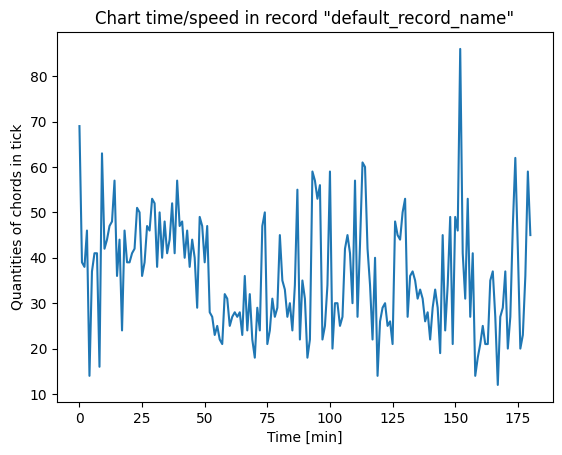

In [15]:
draw_speed_plot(df, get_speed_calculation(df), y_name = 'chords')

##Chords 2.1

Based on chord detection developed for 1., crate a table with the number of occurances of chords.
Try to use chorder to assign names to detected notes.

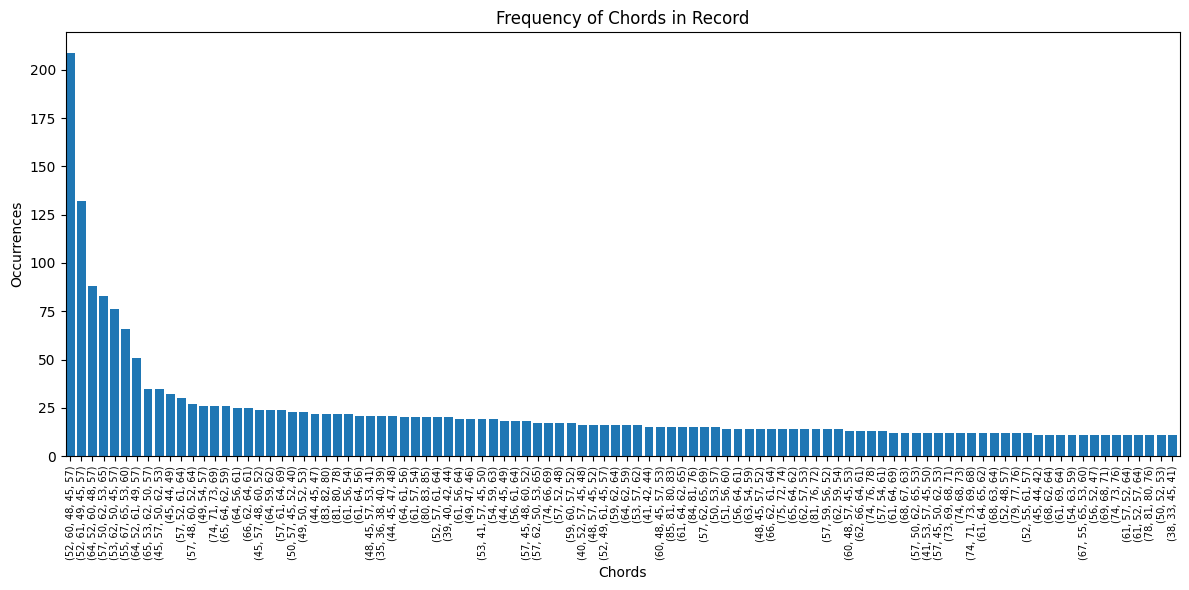

In [16]:
draw_chords_counter_plot(chords, top = 100)

## chord assignment

Here are my attempts to solve the chord assignment problem. I tried to use my code for chord assignment, but I realized that not all detected lists of notes are actually chords. So I am just stuck here. Here's what has been done:


*   Tried dividing the dataset into octaves to separate the bass line from the melodic line - **Failure** (chords can be played in high or low octave levels depending on the recording).
*   Attempted to add additional conditions related to timing to the chord recognition function - **Failure** (chords can be played with the use of arpeggio technique, so they can be played faster or slower or even simultanously).
* Tried using Dechorder to create a MIDI file and checked how the dedicated library works - **Failure** (after creating a MIDI file based on the loaded dataset, Dechorder did not identify anything in the MIDI file).
* Attempted to use unsupervised clustering methods (KNearestNeighbors) to classify notes as chords - Failure (chords can contain 3 notes as well as 5 groups of notes, so this method did not work well)."



In [17]:
df_copy['Octave'] = df_copy['pitch'] // 12
df_copy['root_pc'] = df_copy['pitch'] % 12
df_copy

,end,pitch,start,velocity,chord,Octave,root_pc
0,2.058438,42,1.934219,74,NaN,3,6
1,2.990469,66,1.935573,84,NaN,5,6
2,2.044531,30,1.948229,76,NaN,2,6
3,2.613073,49,2.556146,77,1.0,4,1
4,2.618333,54,2.564844,59,1.0,4,6
...,...,...,...,...,...,...,...
88882,10856.278125,82,10856.155208,54,6525.0,6,10
88883,10856.724115,65,10856.187188,36,6525.0,5,5
88884,10856.875625,70,10856.732500,34,6525.0,5,10
88885,10856.849063,89,10856.750156,57,NaN,7,5


In [18]:
Chord.default_scale

['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']

In [19]:
mido_obj = mid_parser.MidiFile()
beat_rseol = mido_obj.ticks_per_beat
instrument = containers.Instrument(program=0, is_drum=False, name='example_track')
mido_obj.instruments = [instrument]

for index, row in df.iterrows():
    start= int(row['start'] * beat_rseol)
    end= int(row['end'] * beat_rseol)
    pitch = int(row['pitch'])
    velocity = int(row['velocity'])
    note = containers.Note(start=start, end=end, pitch=pitch, velocity=velocity)
    mido_obj.instruments[0].notes.append(note)

mido_obj.dump('output.midi')

mido_obj_re = mid_parser.MidiFile('output.midi')
for note in mido_obj_re.instruments[0].notes:
    print(note)
    break


Note(start=935, end=981, pitch=30, velocity=76)


In [20]:
len(mido_obj_re.instruments[0].notes)

88887

In [21]:
df

,end,pitch,start,velocity
0,2.058438,42,1.934219,74
1,2.990469,66,1.935573,84
2,2.044531,30,1.948229,76
3,2.613073,49,2.556146,77
4,2.618333,54,2.564844,59
...,...,...,...,...
88882,10856.278125,82,10856.155208,54
88883,10856.724115,65,10856.187188,36
88884,10856.875625,70,10856.732500,34
88885,10856.849063,89,10856.750156,57


In [22]:
from chorder.dechorder import Dechorder

In [23]:
Dechorder.get_chord_quality(mido_obj_re.instruments[0].notes)

(Chord(root_pc=None, quality=None, bass_pc=None), -1)

In [24]:
for note in mido_obj_re.instruments[0].notes:
  a = Dechorder.get_chord_quality(note)
  print(a)
  break

TypeError: ignored

In [ ]:
from datasets import load_dataset

dataset = load_dataset("roszcz/maestro-v1")